This notebook goes through a simple binary classification example, explaining general library functionality and loading along the way.

We perform binary classification on sex, using structural MRI rois.

# Init Phase

In [1]:
from ABCD_ML import *

# The rest of these are just used to help show different things
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The following definition are useful simply as a shorthand for defining long file paths all in one place.

In [2]:
# Base data directories, 2.0 release with most of the phenotype information
nda_dr = '/home/sage/work/ABCD2p0NDA/'

# This folder contains the re-released 2.0.1 fixed MRI derived measurements
nda_dr2 = '/home/sage/work/ABCDFixRelease2p0p1/'

#This file stores the name mapping
map_file = os.path.join(nda_dr2, 'Fix Release Notes 2.0.1_Public', '24. ABCD_Release_2.0.1_Updates',
                        'abcd_2.0.1_mapping.csv')

# Destr atlas structural MRI rois
data1 = os.path.join(nda_dr2, 'abcd_mrisdp101.txt')
data2 = os.path.join(nda_dr2, 'abcd_mrisdp201.txt')

# Family ID
strat1 = os.path.join(nda_dr, 'acspsw03.txt')

We first need to define the class object, which we will use to load load and to train/test different ML models.
There are a few global parameters which we can optionally set when defining this object as well, lets look and see what they are at https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#init

Most of the default parameters are okay for this simple example, but any of them can be changed.

In [3]:
ML = ABCD_ML(exp_name = 'Sex',
             existing_log = 'overwrite',
             use_abcd_subject_ids = True,
             random_state = 1)

exp_name = Sex
log_dr = /home/sage/ABCD_ML/Examples/Full_Examples
existing_log = overwrite
verbose = True
exp log dr setup at: /home/sage/ABCD_ML/Examples/Full_Examples/Sex
log file at: /home/sage/ABCD_ML/Examples/Full_Examples/Sex/logs.txt
Default params set:
notebook = True
use_abcd_subject_ids = True
low memory mode = False
strat_u_name = _Strat
random state = 1
n_jobs = 1
dpi = 100
mp_context = spawn
ABCD_ML object initialized


# Loading Phase

First we will consider setting default parameters for loading, which can be found at: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#set-default-load-params

In [4]:
ML.Set_Default_Load_Params(dataset_type = 'basic',
                           eventname = 'baseline_year_1_arm_1',
                           eventname_col = 'eventname',
                           drop_na = True)

Default load params set within self.default_load_params.
----------------------
dataset_type: basic
subject_id: src_subject_id
eventname: baseline_year_1_arm_1
eventname_col: eventname
overlap_subjects: False
merge: inner
na_values: ['777', '999']
drop_na: True
drop_or_na: drop



We can continue by optionally loading in a name map, which is simply a dictionary that attempts to rename any column names loaded in, if those column names are a key in the dictionary. This is useful for ABCD data as the default column names might not be useful. This mapping was provided along with the 2.0.1 data release. See: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-name-map

In [5]:
ML.Load_Name_Map(loc = map_file,
                 dataset_type = 'explorer',
                 source_name_col = 'nda_name',
                 target_name_col = 'deap_name')

Loading /home/sage/work/ABCDFixRelease2p0p1/Fix Release Notes 2.0.1_Public/24. ABCD_Release_2.0.1_Updates/abcd_2.0.1_mapping.csv  with dataset type: explorer
Loading new name_map from file!


In [11]:
import json
with open('/home/sage/BPt/data/sources/custom/abcd_mapping.json', 'w') as f:
    json.dump(ML.name_map, f)


In [28]:
ML.Load_Targets(loc=data1,
                col_name = 'sex',
                data_type='b')

Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 1 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

loading: sex

Loaded Shape: (11533, 1)
All loaded targets
0 : sex



cleared strat.

Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0
Binarizing interview_age_Strat
Setting: 6077 as 0.
Setting: 5457 as 1.
Loaded Shape: (11534, 1)
Set to overlapping loaded subjects.
-- interview_age_Strat --


,Original_Name,Counts,Frequency
Internal_Name,,,
0,<120,6076,0.526836
1,>=120,5457,0.473164


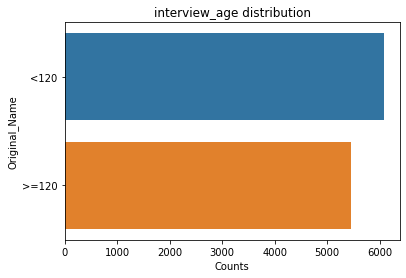

In [29]:
ML.Load_Strat(loc=data1,
              col_name = 'interview_age',
              clear_existing = True,
              float_to_binary = 120)
ML.Show_Strat_Dist()

cleared covars.

Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0
loading: interview_age(b)
Dropped value(s) [107 132] according to passed drop percent of 0.02
Dropped 261 rows based on filter input params, e.g. filter outlier percent, drop cat, ect...
Loaded Shape: (11273, 1)
Set to overlapping loaded subjects.
-- interview_age(b) --


,Original_Name,Counts,Frequency
Internal_Name,,,
0.0,108.0,879,0.077981
1.0,109.0,633,0.056157
2.0,110.0,534,0.047374
3.0,111.0,465,0.041253
4.0,112.0,378,0.033534
5.0,113.0,401,0.035575
6.0,114.0,419,0.037172
7.0,115.0,433,0.038414
8.0,116.0,462,0.040987


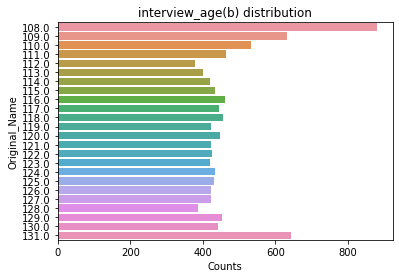

In [7]:
ML.Load_Covars(loc=data1,
               col_name=['interview_age'],
               data_type='cat',
               clear_existing=True,
               code_categorical_as='dummy',
               categorical_drop_percent=.02,
               ext = '(b)'
              )

ML.Show_Covars_Dist()

In [30]:
some_examples = {k: ML.name_map[k] for k in list(ML.name_map)[300:320]}
some_examples

{'ddtidp_119': 'dmri_dti.fa.wm_cort.destrieux_s.central.rh',
 'ddtidp_120': 'dmri_dti.fa.wm_cort.destrieux_s.cingul.marginalis.rh',
 'ddtidp_121': 'dmri_dti.fa.wm_cort.destrieux_s.circular.insula.ant.rh',
 'ddtidp_122': 'dmri_dti.fa.wm_cort.destrieux_s.circular.insula.inf.rh',
 'ddtidp_123': 'dmri_dti.fa.wm_cort.destrieux_s.circular.insula.sup.rh',
 'ddtidp_124': 'dmri_dti.fa.wm_cort.destrieux_s.collat.transv.ant.rh',
 'ddtidp_125': 'dmri_dti.fa.wm_cort.destrieux_s.collat.transv.post.rh',
 'ddtidp_126': 'dmri_dti.fa.wm_cort.destrieux_s.front.inf.rh',
 'ddtidp_127': 'dmri_dti.fa.wm_cort.destrieux_s.front.middle.rh',
 'ddtidp_128': 'dmri_dti.fa.wm_cort.destrieux_s.front.sup.rh',
 'ddtidp_129': 'dmri_dti.fa.wm_cort.destrieux_s.interm.prim.jensen.rh',
 'ddtidp_130': 'dmri_dti.fa.wm_cort.destrieux_s.intrapariet.and.p.trans.rh',
 'ddtidp_131': 'dmri_dti.fa.wm_cort.destrieux_s.oc.middle.and.lunatus.rh',
 'ddtidp_132': 'dmri_dti.fa.wm_cort.destrieux_s.oc.sup.and.transversal.rh',
 'ddtidp_133':

The next step to consider is in if there are any subjects which should be apriori excluded. These can be defined as either a list of subjects to exclude, or as a list of subjects to include (where only those subjects that appear in the list would be kept).

See:

- https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-exclusions

- https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-inclusions

In this example we will not define any.

Next, we will load in the actual data of interest. You will note when looking at the help function that all of the parameter we set in the defaults can also be set here as well, or if we want to keep the default params, we just leave the values as is.

See: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-data


In [31]:
ML.Load_Data(loc=[data1, data2],
             ext='(b)')

Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type
Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 0 cols for all missing values
Dropped 2892 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

Processing unique col values with drop threshold: 0 - warn threshold: 432.1 - out of 8642 rows
Warn - smri_area_cort.destrieux_g.front.inf.orbital.lh(b) has unique vals: 300
Warn - smri_area_cort.destrieux_g.ins.lg.and.s.cent.ins.lh(b) has unique 

In [32]:
ML.data

,smri_thick_cort.destrieux_g.and.s.frontomargin.lh(b),smri_thick_cort.destrieux_g.and.s.occipital.inf.lh(b),smri_thick_cort.destrieux_g.and.s.paracentral.lh(b),smri_thick_cort.destrieux_g.and.s.subcentral.lh(b),smri_thick_cort.destrieux_g.and.s.transv.frontopol.lh(b),smri_thick_cort.destrieux_g.and.s.cingul.ant.lh(b),smri_thick_cort.destrieux_g.and.s.cingul.mid.ant.lh(b),smri_thick_cort.destrieux_g.and.s.cingul.mid.post.lh(b),smri_thick_cort.destrieux_g.cingul.post.dorsal.lh(b),smri_thick_cort.destrieux_g.cingul.post.ventral.lh(b),...,smri_t2w.contrast_cort.destrieux_s.precentral.inf.part.rh(b),smri_t2w.contrast_cort.destrieux_s.precentral.sup.part.rh(b),smri_t2w.contrast_cort.destrieux_s.suborbital.rh(b),smri_t2w.contrast_cort.destrieux_s.subparietal.rh(b),smri_t2w.contrast_cort.destrieux_s.temporal.inf.rh(b),smri_t2w.contrast_cort.destrieux_s.temporal.sup.rh(b),smri_t2w.contrast_cort.destrieux_s.temporal.transverse.rh(b),smri_t2w.contrast_cort.destrieux_mean.lh(b),smri_t2w.contrast_cort.destrieux_mean.rh(b),smri_t2w.contrast_cort.destrieux_mean(b)
src_subject_id,,,,,,,,,,,,,,,,,,,,,
NDAR_INVTK4DJ93H,2.566,2.264,2.129,2.991,3.079,2.930,2.757,2.758,3.207,3.040,...,-0.064891,-0.054464,-0.074359,-0.070335,-0.076025,-0.071395,-0.079813,-0.048968,-0.047173,-0.048065
NDAR_INVB2DX8YD7,2.780,2.760,2.388,2.771,3.014,2.921,2.721,2.705,3.189,2.377,...,-0.059263,-0.055367,-0.079465,-0.053663,-0.073469,-0.066579,-0.065031,-0.043166,-0.046157,-0.044656
NDAR_INVZDLAWZZL,2.559,2.873,2.818,3.204,3.010,3.121,2.987,2.859,3.348,2.943,...,-0.077273,-0.071355,-0.109950,-0.096072,-0.080885,-0.086107,-0.070973,-0.066038,-0.066082,-0.066060
NDAR_INV85W58U88,2.521,2.934,2.769,3.021,3.029,3.094,3.059,2.919,3.079,3.090,...,-0.099024,-0.093964,-0.144186,-0.117694,-0.121687,-0.103735,-0.106336,-0.084448,-0.083982,-0.084215
NDAR_INVWT13MP64,2.862,2.625,2.403,2.856,2.880,3.012,2.993,3.112,3.411,2.141,...,-0.083565,-0.071195,-0.086150,-0.089915,-0.097587,-0.101810,-0.071571,-0.069308,-0.069666,-0.069487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVCYMF7WT5,2.628,2.683,2.601,2.800,3.139,2.787,2.865,2.881,3.293,2.567,...,-0.066182,-0.064147,-0.079195,-0.059806,-0.082640,-0.070042,-0.082734,-0.053253,-0.052462,-0.052852
NDAR_INVACZZH8LM,2.920,2.796,2.794,3.207,2.942,3.391,3.172,3.026,3.296,2.722,...,-0.080198,-0.078146,-0.086585,-0.079060,-0.094880,-0.084526,-0.079828,-0.063838,-0.064034,-0.063936
NDAR_INV4LX4UUWE,2.138,2.828,2.487,2.899,2.651,2.748,2.691,2.833,3.204,2.323,...,-0.070923,-0.061995,-0.087477,-0.087313,-0.082820,-0.084258,-0.097347,-0.056184,-0.056804,-0.056495


By default the loading data function has warned us about some columns with a suspiciously low number of unique values, and also note that they are all surface area, so maybe that is expected. Lets turn warn off in the future

The other alarming thing to note is we are losing 2892 rows for missing values. One way we can examine this further is to re-load the data, but without dropping any missing values.

In [33]:
ML.Load_Data(loc = [data1, data2],
             unique_val_warn = None,
             drop_na = False,
             clear_existing = True # Make sure to call clear_existing if re-loading the same data!
             )

Cleared loaded data.

Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type
Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 0 cols for all missing values
Loaded rows with NaN remaining: 2892
Loaded NaN Info:
There are: 284244 total missing values
437 columns found with 4 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
435 columns found with 617 missing values (column name overlap: ['_cort.destrieux_', 'smri_t2w.'])
18 columns found with 1 missing values (column name overlap: ['_cort.destrieux_'

Now we are provided some more detailed information about what NaN columns are loaded. This is useful because we can note there are 435 columns found with 617 missing values, and of those 435 columns, 'smri_t2w.' is one of the keys present in all of them. In this case, what we can do is try not loading t2w rois, as it is clear some number of subjects just didn't get a t2 scan. 

In [34]:
ML.Load_Data(loc = [data1, data2],
             unique_val_warn = None,
             drop_keys = 'smri_t2w.',
             drop_na = False,
             clear_existing = True
             )

Cleared loaded data.

Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type
Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 453 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Loaded rows with NaN remaining: 2396
Loaded NaN Info:
There are: 4680 total missing values
437 columns found with 4 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
18 columns found with 1 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
12 columns found with 5 missing values 

We now have a few different options for how we want to handle the rest of the NaN's. The first is to either just drop all of them, but as evident by 437 columns found with 4 missing values, it might be the case that there are just a few subjects with a messed up scan, and therefore a bunch of NaN's. We can try setting drop_nan to 10. In that case, only subjects with less then or equal to 10 NaNs will be kept.

In [35]:
ML.Load_Data(loc = [data1, data2],
             unique_val_warn = None,
             drop_keys = 'smri_t2w.',
             drop_na = 10,
             clear_existing = True
             )

Cleared loaded data.

Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type
Loading /home/sage/work/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 453 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Dropped 12 rows for missing values, based on the provided drop_na param: 10 with actual na_thresh: 10
Loaded rows with NaN remaining: 2384
Loaded NaN Info:
There are: 2697 total missing values
12 columns found with 1 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
7 columns found with 2 missing

Okay great. Now we have 2384 subjects with atleast one NaN value to impute, but we know that all of those subjects only have 1-10 missing values, and likewise, no single feature seems to have all that many NaN's. We now have 11522 subjects and still 1057 features.

We can check the data distribution visually too for a few random ROIs.

In [36]:
# Note this function will break unless you have ffmpeg installed on your machine, so it is commented out here.
#ML.Show_Data_Dist()

There does not appear to be too many big outliers in the dataset (some, but...), lets avoid doing any outlier dropping in this example, and instead if it is a problem deal with it during modelling. In general, there are a number of methods for dropping outliers or performing other proc on the loaded data either built into Load_Data or as an external function, e.g., Proc_Data_Unique_Cols https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#proc-data-unique-cols

We will load our target variable next. See: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-targets

Again, a number of the default load params are accesible when loading targets too in case they need to change. We again need to only use fairly simple functionality here, loading in the sex column from our structural mris (as some bugs with sex were fixed in release 2.0.1). 

One thing to note when plotting the Show_Targets_Dist is the printed "Set to overlapping loaded subjects.", which means we are only seeing the targets distribution based on the overlap of all subjects currently loaded (so right now that is just the overlap with data). This can be set off in the case we want to see, in this case, the few subjects who will be eventually lost.

We can look into adding covars next. Where co-variates arn't quite treated as typical co-variates, but are values we would like to be able to pass as additional input to the ML model if desired (and input that can be treated with special care). This example will actually skip this step though.

Lastly, we will considering loading different stratification values. These are the values that we can optionally define custom validation / split behavior on. Within this example, we are just going to make sure that all splits preserve subjects with the same family id within the same fold, so lets load family id - after looking as the help function. See: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#load-strat

In [37]:
ML.Load_Strat(loc=strat1,
              col_name='rel_family_id')

Loading /home/sage/work/ABCD2p0NDA/acspsw03.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 2 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0
Loaded Shape: (11873, 1)
Merged with existing (merge=inner)
New combined shape: (11532, 2)


Great, we now have all the data we will need loaded (Noting that the minimum requiriments for running an ML expiriment are just data or covars and targets, the rest being optional). The actual length of the script is also not as terrible as it seems, and once loading behavior is confirmed, verbose can even be turned off. In practice also, there is no reason why the user should not just keep reloading data, with changes to params, within the same cell by re-running it - which would defeat the point of a tutorial, but would greatly help readability!

# Validation Phase

Lets move onto defining our validation stratagy (which is again optional, but as stated before for this example we are going to preserve family ids within the same folds), if no explicit validation strategy is defined, then random splits will be used. See: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#validation-phase

So for group preserving behavior, as we are interested in keep families within the same folds, we supply an argument for groups. Specifically, we use the name of the column loaded within self.strat

Notably as well is that defining a validation strategy is used to define global split behavior, which means the defined validation behavior will effect the train test split, as well as the internal splits used in modelling. We can re-define the original validation strategy at any point, even after defining a global train test split (why? e.g., in order to test within just the train set the effect of putting all the subjects with any nan as train only)

The extra feature we will add to the split is defining all subjects with any missing measurements to be train only, this means these subjects will always be put in the training fold, in both the global split and for internal CV and even nested internal parameter search CV.

In [38]:
ML.Define_Validation_Strategy(groups='rel_family_id', train_only_subjects='nan')

2323 Train only subjects defined.
Those subjects are excluded from the below stats!

CV defined with group preserving over 7882 unique values.


Note explictly, "Preparing final data, in self.all_data
Any changes to loaded data, covars or strat will not be included, from now on."

If you want to load new data or a new target for example, you need to restart the notebook, as any changes made with loading functions will not effect the data to be used in modeling and testing ect...

Lastly before we get to modelling, we want to define a global train-test split, so that we can perform model exploration, and parameter tuning ect... on a training set, and leave a left-out testing set to eventually test with out final selected model. See: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#train-test-split

In [39]:
ML.Train_Test_Split(test_size=.35) #Lets use .35, as train only subjects will not be considered

Performing split on 8339 subjects with 2919 considered train only!
random_state: 1
Test split size: 0.35

Performed train test split
Train size: 8336
Test size:  2922


Note above for the curious, 3003 subjects are considered train only, event though we only had 2384 with NaN. This is because we are defining group preserving behavior on family id, so not only do we need to keep those subjects in the training set, but keep all of their family members in the training set. We know now that no family id is in both the train and test set - but for the perhaps rightfully paranoid we can make sure of this.

In [40]:
train_ids = set(ML.strat['rel_family_id_Strat'].loc[ML.train_subjects])
test_ids = set(ML.strat['rel_family_id_Strat'].loc[ML.test_subjects])

print('Unique family ids in train: ', len(train_ids))
print('Unique family ids in test: ', len(test_ids))
print('Overlap : ', len(train_ids.intersection(test_ids)))

Unique family ids in train:  6985
Unique family ids in test:  2557
Overlap :  0


Here might also be a good time to save a copy of the object we have created, if that is desired behavior. We are going to save it in our defined log_dr, and use the low_memory flag, which doesn't save explicitly loaded self.data, self.covars ect... and just stores the final self.all_data for modelling (which we have already implicitly created). Let's try it out.

In [41]:
save_loc = os.path.join(ML.exp_log_dr, 'Sex.ML')
ML.Save(save_loc, low_memory=True)

Now first thing to note is, since we set low_memory to false, we will can see that data, and targets ect.. are now deleted.

In [42]:
ML.data.shape, ML.targets.shape

((0, 0), (0, 0))

And only all_data remains.

In [43]:
ML.all_data.shape

(11258, 1060)

We can for example now delete our original ML object and then re-load the saved one

In [44]:
del ML
ML = Load(save_loc)

ABCD_ML object loaded from save!


And make sure it worked. 

In [45]:
ML.all_data.shape

(11258, 1060)

# Modeling Phase

Within modeling, what we are concerned with is building and first Evaluating different Model_Pipelines. We will first start though by defing what is called a Problem_Spec, which contains essentially our specifications for what ML expiriment we want to run exactly. Note: Problem_Spec is imported at the start with from ABCD_ML import *, but for Problem_Spec and the rest of the special classes we will use you can also import them specifically, i.e., from ABCD_ML import Problem_Spec

In [46]:
problem_spec = Problem_Spec(problem_type = 'categorical', # As this is a binary problem
                            metric = ['roc_auc'], # Good thresholded and non-thresholded binary metrics
                            n_jobs = 8)
problem_spec               

Problem_Spec(metric=['roc_auc'], n_jobs=8, problem_type='categorical')

We can also specify some default parameters for different levels of verbose output during modelling. See: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#set-default-ml-verbosity

In [47]:
ML.Set_Default_ML_Verbosity()  # Default are fine

Default ML verbosity set within self.default_ML_verbosity.
----------------------
save_results: False
progress_bar: True
compute_train_score: False
show_init_params: True
fold_name: False
time_per_fold: False
score_per_fold: False
fold_sizes: False
best_params: False
save_to_logs: False



Now we can proceed to building our Model_Pipeline - where a Model_Pipeline is constructed as a number of individual Pipeline pieces, all of which we have imported. Let's start by first just specifying a Model_Pipeline with just the default pre-set values for everything but Model, we will specify a custom Model.

In [48]:
# We will use a decision tree as our base model
model = Model('dt')

model_pipeline = Model_Pipeline(model = model)
model_pipeline.print_all()

Model_Pipeline
--------------
imputers=\
[Imputer(extra_params={}, obj='mean', scope='float'),
 Imputer(extra_params={}, obj='median', scope='cat')]

scalers=\
Scaler(extra_params={}, obj='standard')

model=\
Model(extra_params={}, obj='dt')

param_search=\
None

feat_importances=\
Feat_Importance(obj='base', shap_params=None)




We can see that the their are a few default values, specifically we have a set of default imputers, one for replacing all float variables with the mean value, and one for replacing all categorical / binary variables (if any, otherwise ignored) with the median values.

Next, we have a just standard scaler, which scales all features to have mean 0, std of 1.

Then, we have our decision tree.

Lastly, we have no param_search specified, and also we are keeping track of 'base' feature importances, which means for a linear model, just the beta weights.

Now that we have an initial model, we are ready to use the Evaluate function, see: https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html#evaluate

In [49]:
results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      splits = 3,
                      n_repeats = 1)

Model_Pipeline
--------------
imputers=\
[Imputer(extra_params={}, obj='mean', scope='float'),
 Imputer(extra_params={}, obj='median', scope='cat')]

scalers=\
Scaler(extra_params={}, obj='standard')

model=\
Model(extra_params={}, obj='dt')

param_search=\
None

feat_importances=\
Feat_Importance(obj='base', shap_params=None)


Problem_Spec
------------
problem_type = categorical
target = sex
metric = ['roc_auc']
weight_metric = False
scope = all
subjects = all
len(subjects) = 11258 (before overlap w/ train/test subjects)
n_jobs 8
random_state 1

Evaluate Params
---------------
splits = 3
n_repeats = 1
CV = default
train_subjects = train
len(train_subjects) = 8336 (before overlap w/ problem_spec.subjects)
run_name = dt0






Validation Scores
_________________
Metric:  roc_auc
Mean Validation score:  0.64546905750897
Std in Validation score:  0.0037682330224783006



In [52]:
results['raw_preds']

,1_prob_class_0.0,1_prob_class_1.0,1,1_fold,sex
NDAR_INVTK4DJ93H,1.0,0.0,0.0,3,1.0
NDAR_INVTF4Z1FJ3,NaN,NaN,NaN,NaN,NaN
NDAR_INVZDLAWZZL,1.0,0.0,0.0,2,0.0
NDAR_INV85W58U88,0.0,1.0,1.0,1,1.0
NDAR_INVWT13MP64,0.0,1.0,1.0,2,1.0
...,...,...,...,...,...
NDAR_INVKX88859E,NaN,NaN,NaN,NaN,NaN
NDAR_INVACZZH8LM,0.0,1.0,1.0,2,0.0
NDAR_INV4LX4UUWE,1.0,0.0,0.0,2,0.0
NDAR_INV4MPM83XL,0.0,1.0,1.0,3,1.0


First off, its clear that running the full evaluation even with a very quick simple model like the decision tree if very intensive, all we have 1000+ features and thousands of subjects. One optional trick we can use, especially for this example, is to run expiriments with only a subset of the features, let's consider what we have loaded:

- 'smri_thick_cort'
- 'smri_sulc_cort'
- 'smri_area_cort'
- 'smri_vol_cort'
- 'smri_t1w.white02_cort'
- 'smri_t1w.gray02_cort'
- 'smri_t1w.contrast_cort'

Alright, so let's say we are only interested in cortical thickness - to limit our Evaluate call to using just cortical thickness features, all we have to do is provide that substring from above, 'smri_thick_cort', to the scope of our problem_spec.

In [ ]:
# Instead of defining a new problem_spec object, we can just update the value
problem_spec.scope = 'smri_thick_cort'

# Now re-run Evaluate
results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      splits = 3,
                      n_repeats = 1)

Even though this model did worse, we really didn't expect much from the decision tree model, and it was faster.

Let's try a just linear model now (Logistic Regression, since binary), updating our model within our model_pipeline first.

In [ ]:
model_pipeline.model = Model('linear')

results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      n_repeats = 1)

A just linear model appears to do much better then the decision tree. Before we try other models, let's take a look at the beta weights from the linear model (averaged over the 6 models, 2 repeated, 3 folds). A short hand for this is by just calling plot global feat importances directly, which will plot the feature importances for the last Evaluate call, though it is also worth exploring the results dictionary which is returned from Evaluate!

In [ ]:
ML.Plot_Global_Feat_Importances()

In [ ]:
# If we passed multiple feature importances to calculate they would appear in a list, 
print(len(results['FIs']))

# If we show this object we see
results['FIs'][0]

In [ ]:
# We can either look at the importances in a dataframe, or pass the feature importance object to the plotting func
results['FIs'][0].global_df

In [ ]:
ML.Plot_Global_Feat_Importances(results['FIs'][0])

Interesting, so the biggest features driving the model to predict female (0) vs. male (1) are the mean thickness of the different hemispheres. Luckily, we are not interested in actually solving a problem in this example, but instead illustrating usage of the library, so lets move on to trying some more advanced models.

Let's explore some different models before sticking with this straight linear one. One of my favorites to try is light gradient boosting machine, or light gbm (or lgbm). 

Note: lightgbm is not included in ABCD_ML's pip requiriments by default as on mac's especially there are some extra download steps. If you have not already, and would like to use the lightgbm package, please install the lightgbm packagae on your machine.

In [ ]:
model_pipeline.model = Model('light gbm')

results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      n_repeats = 1)

Up until this point we have not been exploring any nested hyper-parameters, which for a linear and decision tree model is not a big deal, but fine tuning the lightgbm is fairly essential in order to get good performance. To tune parameters facebooks nevergrad package is used a backend optimizer which allows for a lot of interesting search types (https://abcd-ml.readthedocs.io/en/latest/search_types.html), but introduces a little bit of a learning curve for those interested in entering in custom hyperparameter distributions to search over.

By default though, most classifiers have atleast one pre-set hyperparameter distributions to search over. We can see lightgbm's at https://abcd-ml.readthedocs.io/en/latest/options.html#light-gbm-classifier. Our choice here of what search type to use will be passed to the search_type param, and we will just start with a RandomSearch.

To specify that we want to use a parameter search with the light gbm we have to do two things: First specify the param distribution we want to use in the model object itself, second, we want to create a param_search object within out model_pipeline, where right now it is set to None.

In [50]:
model = Model(obj = 'elastic',
              params = 1 # To specify we want to use the preset param dist w/ index 1
             )

param_search = Param_Search(search_type = 'RandomSearch',
                            n_iter = 50)

# Now we can update our model_pipeline
model_pipeline.model = model
model_pipeline.param_search = param_search

# And re-run Evaluate
results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      n_repeats = 1)

Model_Pipeline
--------------
imputers=\
[Imputer(extra_params={}, obj='mean'),
 Imputer(extra_params={}, obj='median', scope='cat')]

scalers=\
Scaler(extra_params={}, obj='standard')

model=\
Model(extra_params={}, obj='elastic', params=1)

param_search=\
Param_Search(mp_context='spawn', n_iter=50)

feat_importances=\
Feat_Importance(obj='base', shap_params=None)


Problem_Spec
------------
problem_type = binary
target = sex
metric = ['matthews', 'roc auc']
weight_metric = False
scope = all
subjects = all
len(subjects) = 11258 (before overlap w/ train/test subjects)
n_jobs 8
random_state 1

Evaluate Params
---------------
splits = 3
n_repeats = 1
train_subjects = train
len(train_subjects) = 8336 (before overlap w/ problem_spec.subjects)
run_name = elastic



AttributeError: 'OneHotEncoder' object has no attribute 'drop_idx_'

Regardless of a search over params, our linear model still performs best.
Let's try some other linear models then-

In [ ]:
model_pipeline.model = Model('elastic net', params=1)

results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      n_repeats = 1)

In [ ]:
model_pipeline.model = Model('ridge', params=1)

results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      n_repeats = 1)

There are besides model, a whole bunch of other pipeline pieces you can change, e.g., scaler

In [ ]:
model_pipeline.scaler = Scaler('robust')

results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      n_repeats = 1)

That is it for this example - for now, I have plans though to update it more with a more detailed dive into modeling --- and also to include the Test feature.